#  Ideal bandwidths and PDF functions 

Based on kde_tutorial from https://github.com/saint-germain/population_synthesis/blob/master/tools/kde_tutorial.ipynb

## Libraries and data
The data trataiment:

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [4]:
dn=pd.read_csv('data/proc_no_pert.csv',index_col=None) #without pertubtations 
dn["gia"]=dn.ngi>0
dl=pd.read_csv('data/proc_lo_pert.csv',index_col=None) #with low pertubtations 
dl["gia"]=dl.ngi>0
dh=pd.read_csv('data/proc_hi_pert.csv',index_col=None) #with high pertubtations 
dh["gia"]=dh.ngi>0

In [5]:
#Terrestrial
dnt=dn[~dn["gia"]] # without pertubtations 
dlt=dl[~dl["gia"]] # low pertubtations 
dht=dh[~dh["gia"]] # high pertubtations 

#Giant 
dng=dn[dn["gia"]]  # without pertubtations 
dlg=dl[dl["gia"]]  # low pertubtations 
dhg=dh[dh["gia"]]  # high without pertubtations 

In [6]:
#print("***************************************")
#print("Total systems                  : "+str(len(dn)))
#print("***************************************")
#print("Total planets - no             : "+str(dn.nplanets.sum().astype(int)))
#print("Giant planets - no             : "+str(dn.ngi.sum().astype(int)))
#print("Systems with giant planets - no: "+str(dn.gia.sum()))
#print("***************************************")

#print("Total planets - lo             : "+str(dl.nplanets.sum().astype(int)))
#print("Giant planets - lo             : "+str(dl.ngi.sum().astype(int)))
#print("Systems with giant planets - lo: "+str(dl.gia.sum()))
#print("***************************************")
#print("Total planets - hi             : "+str(dh.nplanets.sum().astype(int)))
#print("Giant planets - hi             : "+str(dh.ngi.sum().astype(int)))
#print("Systems with giant planets - hi: "+str(dh.gia.sum()))

In [7]:
x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]

for i, var in enumerate(x_variables):
    var['logeff'] = np.log10(var.massefficiency)
    var['logcom'] = np.log10(var.com)

In [8]:
dng.head()

,Unnamed: 0,ident,com,nplanets,massbudget,massefficiency,sigmag0,md,rc,ms,metal,taugas,qest,ngi,mtr,apert,gia,logeff,logcom
0,0,3.0,1.081461,10.0,10770.309627,0.576981,90.793337,0.056,29.539343,0.880114,0.328146,1644710.625,8.421395,4.0,12.004623,0.0,True,-0.238839,0.034011
2,2,6.0,0.110789,12.0,2422.342359,0.060559,75.740878,0.120,47.343380,0.861595,0.021273,1790533.125,4.412694,1.0,29.771089,0.0,True,-1.217824,-0.955504
4,4,13.0,0.172211,13.0,2905.457535,0.051273,178.830700,0.170,36.672222,1.206445,-0.174039,3956707.500,3.998513,1.0,14.220447,0.0,True,-1.290113,-0.763939
16,16,31.0,4.377862,11.0,41.578462,0.001299,86.546084,0.096,39.613728,0.993549,-0.031508,1439538.875,5.991912,1.0,17.716253,0.0,True,-2.886282,0.641262
23,23,40.0,2.144859,13.0,181.982608,0.006578,57.698437,0.083,45.111870,1.037112,0.039315,2374519.750,7.413428,1.0,14.782324,0.0,True,-2.181927,0.331399


## The bandwidth problem
<p style='text-align: justify;'> 
So far we have our data. Now we need to construct their probability density distributions. To do this we employ Kernel Density Estimation (KDE). Let's study how to estimate the shape $\widehat{f}_{h}(x)$ of the funtion which could represents the probability density function: 

$$\widehat{f}_{h}(x)=\frac{1}{n} \sum_{i=1}^{n} K_{h}\left(x-x_{i}\right)=\frac{1}{n h} \sum_{i=1}^{n} K\left(\frac{x-x_{i}}{h}\right).$$

Here $K_{h}$ is a kernel (non-negative function), commonly used: uniform, triangular, biweight, triweight, Epanechnikov, normal, among others. The $h$ parameters is a smoothing constant, it is also called _bandwidth_ (also $bw$) (more information of KDE <a href="https://cran.r-project.org/web/packages/kedd/vignettes/kedd.pdf">here</a>). 
 

### The Bandwidth definition
A very brief definition, from <a href="https://en.wikipedia.org/wiki/Kernel_density_estimation">wikipedia</a>: The bandwidth of a kernel is a free parameter which exhibits a strong influence on the resulting estimate. Basically, it determines the smoothness of the density function. The most common optimality criterion used to select this parameter is the expected risk function: 

$$\operatorname{MISE}(h)=\mathrm{E}\left[\int\left(\hat{f}_{h}(x)-f(x)\right)^{2} d x\right].$$

Also is used the rule-of-thumb bandwidth estimator:

$$h=\left(\frac{4 \hat{\sigma}^{5}}{3 n}\right)^{\frac{1}{5}} \approx 1.06 \hat{\sigma} n^{-1 / 5}.$$

Or Silverman's (1986) rule of thumb:

$$h=0.9 \min \left(\hat{\sigma}, \frac{I Q R}{1.34}\right) n^{-\frac{1}{5}}.$$

Some considrations in the values of $h$. On the one hand, if $h\rightarrow 0$ then we have overfitting, in other words there is no smoothing (plots like sum of delta fuctions).  On the other hand, if $h\rightarrow \infty$, we have a density function completily smoothed.

Now, let's estudy the optimal $h$ ($bw$) using `GridsearshCV` with `cross_validation` for the `KernelDensity` method.  Also we consider `gaussian_kde` to compare the PDF results. We introduce a new funtoion that obtain the bandwidths through `Gaussian_kde` and `KernelDensity`.
</p>

In [9]:
#The variable is a column from dataFrames: 'dng','dlg','dhg','dnt','dlt','dht','dn','dl','dh'
def bw_opt(variable, name, plot=False):

    m=.2; dvariable=0.05; deciamls=2
    
    x = variable/variable.min() 
    x_grid = np.around(np.arange(x.min()-m,x.max()+m,dvariable),deciamls)
    norm, size, cv = 10, 30, 30 # 30-fold cross-validation     
        
    #-------------With CrossValidation:
    #x = 
    grid = GridSearchCV(KernelDensity(), 
                        {'bandwidth': np.linspace(x.min(),x.max()/\
                                                  norm,size)},
                        cv=cv) # max-min (grid)
    grid.fit(x[:, None])
    kde_CV = grid.best_estimator_
    bw_CV  = list(grid.best_params_.values())[0]
    pdf_CV = np.exp(kde_CV.score_samples(x_grid[:,None]))
    
    #-------------Gaussian_KDE:
    kde_G = gaussian_kde(x)
    f = kde_G.covariance_factor()
    bw_KDE =  f * x.std()
    pdf_kde = kde_G.evaluate(x_grid)
    
    #---------Comparative plot: 
    if plot == True: 
        fig, ax = plt.subplots(1,3, figsize=(11, 4), constrained_layout=True, sharex=True, sharey=True)
        #-------CV_plot:
        ax[0].plot(x_grid, pdf_CV, linewidth=2, label='bw=%.4f'%kde_CV.bandwidth)
        ax[0].hist(x,8,density=True, alpha=.3)
        ax[0].legend(loc="upper right")
        ax[0].set_title("Cross Validation")
        #-------kde_plot:
        ax[1].plot(x_grid, pdf_kde, linewidth=2, label='bw=%.4f'%bw_KDE)
        ax[1].hist(x,8,density=True, alpha=.3)
        ax[1].legend(loc="upper right")
        ax[1].set_title("Gausian_kde")
        #-------sns_plot:
        sns.distplot(x,  ax=ax[2], axlabel=False, bins=8,
                     hist_kws={"alpha": .3, "color": 'C1'}, 
                     label='default distplot') 
        ax[2].legend(loc="upper right")
        ax[2].set_title("displot")
        #---------------
        fig.suptitle("variable: "+name, 
                     fontsize=15, horizontalalignment='center')
        plt.show()
    return [bw_CV, bw_KDE]

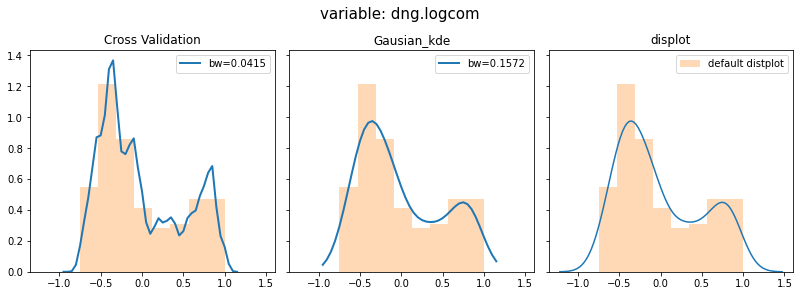

In [10]:
dng_logcom = bw_opt(dhg.logcom, name="dng.logcom", plot=True)

To determine the bw for all data, we can uncomment the following lines.

In [11]:
#%%time
#x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]
#names       = ["dng","dlg","dhg","dnt","dlt","dht","dn","dl","dh"]
#opt_bw_eff  = [] 
##opt_bw_logcom  = [] 

#for index,variable in enumerate(x_variables):
#    print(names[index]+"."+str(variable.logeff.name))
#    bw = bw_opt(variable.logeff, names[index], plot=True)
#    opt_bw_eff.append(bw)

Nevertheless, the results show overfiting, so, it is nessesary to study the bandwidth problem more thoroughly. We implement a seach vector in order to find the scalar hyperparameter of bandwidth. 

## Optimal bandwidth $bw$ and the PDF
<p style='text-align: justify;'> 
    
Now, we stablish a better way to determinie the $bw$ and the PDF for each variable. We implement the `KernelDansity` (through `SearchGridCV`) and `gaussian_kde` as methods of a new class `optimal_bw`. Here we will standarize the data, otherwise, variables measured at different scales do not contribute equally to the analysis. It also heps to determine the ideal bandwith. Therefore, 

- **Standarization**: It is another scaling technique where the values are centered around the mean ($\mu=0$) with a unit as standard deviation ($\sigma=1$). It is important when we compare measurements that have different units, because equalize the range and/or data variability, 

\begin{equation}
X^{\prime}=\frac{X-\mu}{\sigma}.
\end{equation}

#### GridSearchCV Method
We use `GridSearchCV` to estimate the otimal bandwidth $bw$. As the best splitting strategy in cross validation, we take cv$=10$, according with documentaction split the data in more grups is not orthodox, because it does not allow the method to learn with a larger data set.

Finally, in the grid search we employ `KernelDensity` with a Gaussian kernel to generate the PDF for the variable with the ideal $bw$.  

###### The search vector
In the `GridSearchCV` method the optimal $bw$ comes form a scalar hyperparameter, so we introduce it as unidimentional vector. The minimum distance between data is the initial value in the serarch vector. As maximum value of serach we use $3\sigma$ of our data (remember that data are standarized). Finally, the number of steps in the search vector is taken as the ideal for the score of `KernelDensity`.   

#### Gaussian_kde  Method
We use this method as is described in the documentation. 
</p>

In [12]:
class optimal_bw(object):
    
    def __init__(self, variable):
        
        dx, length, decimals = .2, 100, 2 #some constants for the grid of space
        self.variable = variable.values   #original variable
        #standarization:
        self.x = (self.variable-self.variable.mean())/self.variable.std()
        #grid in the std space:
        self.x_grid  = np.around(np.linspace(self.x.min(),
                                            self.x.max(),length),decimals)
        #distance between data
        m = np.abs(np.diff(self.x))      
        self.min = min(m[m>0])
        
    def cv_pdf(self):
        
        cv, nsteps = 10, 50               #some constants 
        
        vector = {'bandwidth': np.linspace(self.min, 3*self.x.std(), nsteps)}
        
        grid = GridSearchCV(KernelDensity(), vector, cv=cv)
        grid.fit(self.x[:, None])
        
        self.bw_CV  = grid.best_estimator_.bandwidth # bw in the standarized space       
        self.bw_1   = self.bw_CV*self.variable.std() # bw in the variable space
        
        self.pdf_CV = np.exp(grid.best_estimator_.score_samples(self.x_grid[:,None]))
        
        #KernelDensity in the variable space with the respective bw
        o_grid = np.around(np.linspace(self.variable.min(), self.variable.max(),100),2)
        kde_org = KernelDensity(bandwidth = self.bw_1).fit(self.variable[:, None])
        self.PDF_1 = np.exp(kde_org.score_samples(o_grid[:, None]))
    
    def kde_pdf(self):
        kde_G = gaussian_kde(self.x)
        
        self.bw_KDE =  kde_G.covariance_factor()      # bw in the standarized space
        self.bw_2 = self.bw_KDE*self.variable.std()   # bw in the variable space
        
        self.pdf_kde = kde_G.evaluate(self.x_grid)
        

So, we implement the methods from `bw_optimal` as, 

In [13]:
ex = optimal_bw(dng.logcom)  #dng.logeff, dng.com, dng.metal
ex.cv_pdf(); 
ex.kde_pdf()

Now, we make a funtion that generates the comparative plot between `gaussian_kde` and `GridSearchCV` methods for get the pdf in the standarized data. 

In [14]:
#needs an object from class bw_optimal
def pdf1D_std(bw, nbins=25):
    lat=12
    fig, ax = plt.subplots(1,2, figsize=(12, 5), constrained_layout=True, sharey=True)

    ax[0].plot(bw.x_grid, bw.pdf_CV, linewidth=2, label='bw=%.3f'%bw.bw_CV)
    ax[0].hist(bw.x, nbins, density=True, alpha=.3, label="standarized data")
    ax[0].legend(loc="upper left", fontsize =lat); ax[0].set_title("KernelDensity", fontsize = lat)

    ax[1].plot(bw.x_grid, bw.pdf_kde, linewidth=2, label='bw=%.3f'%bw.bw_KDE)
    ax[1].hist(bw.x,nbins,density=True, alpha=.3, label="standarized data")
    ax[1].legend(loc="upper left", fontsize=lat)
    ax[1].set_title("Gausian_kde", fontsize=lat)

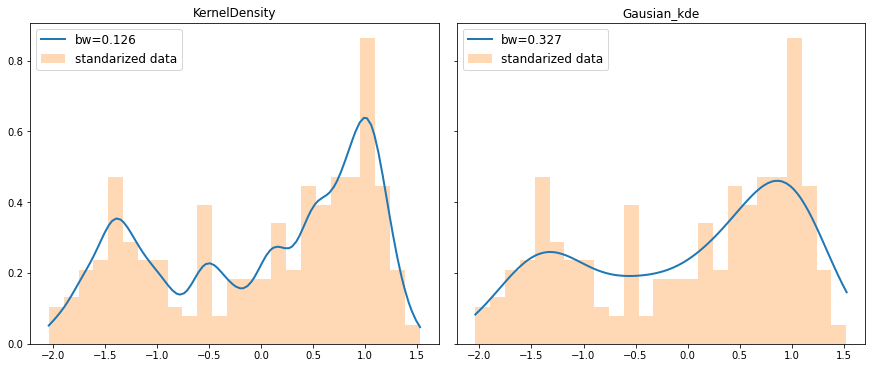

In [15]:
plot = pdf1D_std(ex)

For all the information in the variable `x_variables`

In [16]:
x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]
#for index,variable in enumerate(x_variables):
#    #print(names[index]+"."+str(variable.logcom.name))
#    bw = optimal_bw(variable.logeff)
#    bw.cv_pdf()
#    bw.kde_pdf()
#    plot = pdfs_plot(bw)

If we just plot the PDF obtained in the stanandarized space, in the real space we have some differences respect the data.

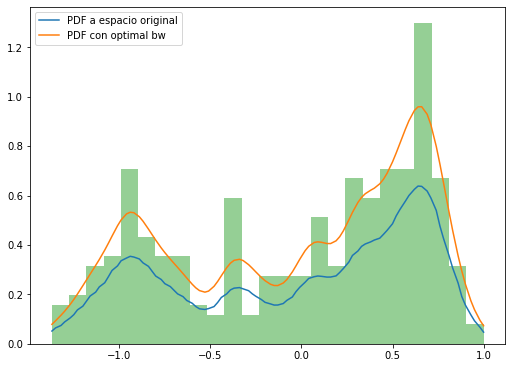

In [17]:
x = dng.logcom.values

o_grid = np.around(np.linspace(x.min(), x.max(),100),2)

fig, ax = plt.subplots(1,1, figsize=(7, 5), constrained_layout=True, sharey=True)


ax.plot(o_grid,ex.pdf_CV, label = "PDF a espacio original")
ax.plot(o_grid, ex.PDF_1, label = "PDF con optimal bw")
ax.hist(x, density = True, alpha=.5, bins= 25)
#ax.set_xlabel("dng.logcom")
plt.legend()

### PDF in the variable space
<p style='text-align: justify;'> 
In order to get the pdf in the variable space, we have two possibilities: 

1. Bring the PDF($X^\prime$) to the original variable space, in the similar way that the reverse process as standarization for the variable with the PDF resulting in the methods of `optimal_bw` class: 

$$X=X^\prime\sigma+\mu$$
   
   Then evaluate PDF($X$).Note that in this option we are not interested in bandwidth, just in take the PDF in the original space. 

2. Make the `KernelDensity` and `gaussian_kde` in the variable space, with the respective $bw$ obtained from standar space and transformed to the variable space. The bandwidth in the variable space $bw$ can be determined as,

$$bw=\sigma bw^\prime.$$

Here, the $bw^\prime$ is the bandwidth in the standarized space, $\sigma$ is the standar deviaton for our data. 

**Let's star with the first option:** 
    
</p>

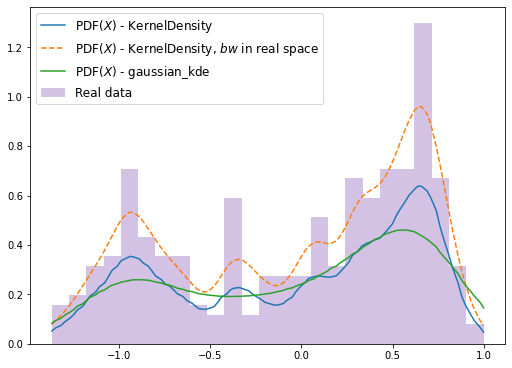

In [18]:
x=np.around(np.linspace(ex.variable.min(),ex.variable.max(),100),2)


fig, ax = plt.subplots(1,1, figsize=(7, 5), constrained_layout=True, sharey=True)

ax.plot(x,ex.pdf_CV, label='PDF($X$) - KernelDensity')
ax.plot(x,ex.PDF_1, label='PDF($X$) - KernelDensity, $bw$ in real space', ls="--")
ax.plot(x,ex.pdf_kde, label='PDF($X$) - gaussian_kde')
ax.hist(ex.variable, bins=25, color="C4", density=True, alpha =.4, label="Real data")
plt.legend(fontsize=12)

<p style='text-align: justify;'> 
Therfore, the first option fails in the height of the PDF and in some cases also fails in the maximum values. It is a problem maybe because the traing data was in the standarized space, then when we change it to the original space the "re-scaling" through linear regression does not work.

**Let's study the second option:**

For the second option, we get the $bw^\prime$ which is the bandwidth in the standarized space, to take it to the variable space, 

$$bw=\sigma bw^\prime.$$
</p>

In [19]:
#grid in the variable space
x_space = np.around(np.linspace(ex.variable.min(),ex.variable.max(),100),2)

#bw in the variable space
BW_1 = ex.bw_CV*ex.variable.std()
BW_2 = ex.bw_KDE*ex.variable.std()
print(BW_1,BW_2)

#pdf in the original space with the ideal bw employing Kernel Density
kde_1d = KernelDensity(bandwidth = BW_1).fit(ex.variable[:, None])
PDF_1  = np.exp(kde_1d.score_samples(x_space[:, None]))

#pdf in the original space with the ideal bw employing Gaussian_KDE
kde_G1d = gaussian_kde(ex.variable, bw_method = BW_2)
PDF_2   = kde_G1d.evaluate(x_space)

0.08389739852553774 0.2173471509485891


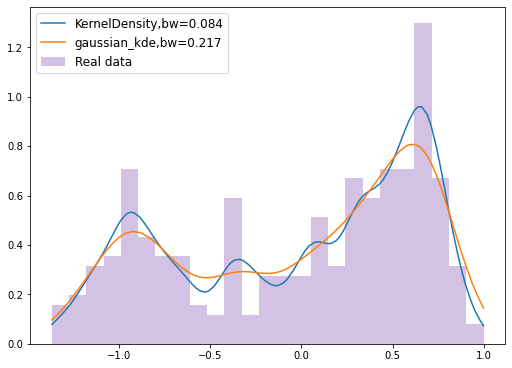

In [20]:
fig, ax = plt.subplots(1,1, figsize=(7, 5), constrained_layout=True, sharey=True)

ax.hist(ex.variable, bins=25, color="C4", density=True, alpha =.4, label="Real data")
plt.plot(x_space,PDF_1, label ="KernelDensity," + "bw=%.3f"%BW_1)
plt.plot(x_space,PDF_2, label ="gaussian_kde," + "bw=%.3f"%BW_2)

plt.legend(fontsize=12)

In [21]:
kde_1d.score(x_space[:, None])

-102.31623818311058

<p style='text-align: justify;'> 
Due to the $bw$ in the original space is the result of the product of the bandwidth in the standarized space $bw^{\prime}$ times the standar deviation $\sigma$, this problem could be dificult to solve for more than 1D. In other words, for 2D, 3D,..., $n$D, we have $n$ different deviations $\sigma$, so what is the ideal to get the $bw$? We do not have idea of what is the optimal $\sigma$ to get $bw$. Besides, the hyperparameter of $bw$ is a scaral no matter how many variables we have. 

However, we can score the best fit for `KernelDensity` using the differents values f $bw$ resulting of the product of the optimum in the standardized space $bw^\prime$, times each of the data deviations $\sigma_1,\sigma_2,...,\sigma_n$.
</p> 


## Bandwiths for  2-D and 3-D
We are going to study the bw problem for more than one dimension. We will use `KernelDensity` to obtain the PDF for the variables in the standarized space PDF($X^\prime$)

### 2D Example

similar function that has standarized data and emply the methods in the class `optimal_bw`

In [22]:
#needs two objects from class bw_optimal, which are normalized or standarized 
def bi_kde(data_x,data_y):
    
    x_grid = data_x.x_grid
    y_grid = data_y.x_grid
    m = [data_x.min,data_y.min]
    
    #grid = KernelDensity() # para hacer pruebas
    
    grid = GridSearchCV(KernelDensity(), 
                        {'bandwidth': np.linspace(min(m),
                                                  3*data_x.x.std(),
                                                  50)}, cv=10)
    #xx = np.vstack([data_x.x,data_y.x]).T
    #print(len(xx))
    grid.fit(np.vstack([data_x.x,data_y.x]).T)
    print(grid.best_params_)
    
    X, Y = np.meshgrid(x_grid, y_grid)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    #print(len(xy))
    kde2d = grid.best_estimator_
    pdf2d = np.exp(kde2d.score_samples(xy)).reshape(X.shape) #get the pdf
    
    plt.figure(figsize=(5,5))
    plt.contourf(X, Y, pdf2d, levels=30, cmap=plt.cm.Reds)
    
    return pdf2d

{'bandwidth': 0.24846383182056772}


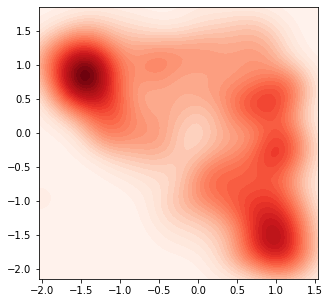

In [23]:
ex_2d = bi_kde(optimal_bw(dng.logcom),optimal_bw(dng.logeff))

### 3D example

Just an example with 3 variables with standarized data.

In [24]:
#---------------------Data:
x2 = (dng.logeff-dng.logeff.mean())/dng.logeff.std()
y2 = (dng.logcom-dng.logcom.mean())/dng.logcom.std()
z2 = (dng.nplanets-dng.nplanets.mean())/dng.nplanets.std()
#z2 = dng.nplanets

data2 = np.vstack([x2,y2,z2]).T

#---------------------Grid:
x2_grid=np.around(np.linspace(x2.min(),x2.max(),30),2)
y2_grid=np.linspace(y2.min(),y2.max(),len(x2_grid))
z2_grid=np.linspace(z2.min(),z2.max(),len(x2_grid))

X2,Y2,Z2 = np.meshgrid(x2_grid, y2_grid, z2_grid)
xyz2   = np.vstack([X2.ravel(), Y2.ravel(), Z2.ravel()]).T


m=np.abs(np.diff([x2,y2,z2]))        #distance between data
var_min=min(m[m>0])

#----------------------CV:

grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(var_min,3*x2.std(),50)},
                    cv=20) # 20-fold cross-validation
grid.fit(data2)

kde3d_2 = grid.best_estimator_
pdf3d_2 = np.exp(kde3d_2.score_samples(xyz2)).reshape(Z2.shape) #get the pdf

The plot of PDF($X^\prime$), employing `plotly`.

In [25]:
len(data2)

268

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

density_2 = pdf3d_2.ravel()

fig = go.Figure(data=go.Volume(
    x=X2.flatten(),
    y=Y2.flatten(),
    z=Z2.flatten(),
    value=density_2.flatten(),
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=30, # needs to be a large number for good volume rendering
    ))
#fig.show()

The above examples for 2D and 3D were for the standarised data. Thus, it is nessesary bring them to the variable space according to the previous options. 

## Multidimensional case
<p style='text-align: justify;'> 
It is time to obtain the bw and the PDF for any dimensionality. At this point, we use the `GridSearchCV` for the `KernelDensity` method, to obtain the ideal bw and the PDF function. 

The search vector has the same the same spirit: an initial value which is the minimum disntance betweeen the data and 3 times the standard deviation of our normalized data. Finally, the number of steps in the search vector is taken as the ideal for the optimal score of `KernelDensity`. 

Again, we will use as the best splitting strategy in cross validation cv$=10$.
</p> 


In [27]:
class optimal_pdf(object):

    def __init__(self, *args):
        
        self.dim  = len(args)
        self.data = np.vstack([*args]).T
        self.data_std = (self.data-np.mean(self.data, axis=0))/np.std(self.data, axis=0) # standarization
        
    def grids(self): 
        #lenght is the size of space in 1D.  
        lenght = 100; self.real_interval, self.std_interval = [], []
        
        for i in range(self.dim):
            self.real_interval.append(np.linspace(self.data[:,i].min(),self.data[:,i].max(),lenght))
            self.std_interval.append(np.linspace(self.data_std[:,i].min(),self.data_std[:,i].max(),lenght))
        
        self.real_grid = np.meshgrid(*self.real_interval)        # PROBLEM MEMORY FOR 5D,6D... nD.
        self.std_grid  = np.meshgrid(*self.std_interval)         # PROBLEM MEMORY FOR 5D,6D... nD.
        # std
        std = [self.std_grid[i].ravel() for i in range(len(self.std_grid))];    self.space_std = np.vstack([*std]).T
        # real
        real = [self.real_grid[i].ravel() for i in range(len(self.real_grid))]; self.space_real = np.vstack([*real]).T
        
    def bw(self):
        # Variables:
        lenght, cv = 50, 10  
        dmin = np.abs(np.diff(self.data_std, axis=0))[np.abs(np.diff(self.data_std, axis=0))>0].min()
        # Search vector
        V_search = {'bandwidth':np.linspace(dmin, 3*self.data_std.std(), lenght)}
        # GridSearchCV
        self.grid_std = GridSearchCV(KernelDensity(), V_search, cv = cv).fit(self.data_std)
        # bw
        self.bw_std  = self.grid_std.best_estimator_.bandwidth
    
    def pdf(self):
        # initialize the above methods 
        self.bw(); self.grids()
        self.scores, kde_i = [], []
        #std
        self.pdf_std = np.exp(self.grid_std.best_estimator_.score_samples(self.space_std).reshape(self.std_grid[0].shape))        
        #real
        bws  = self.bw_std*np.std(self.data, axis=0); 
        
        for i in range(len(bws)):
            kde_i.append(KernelDensity(bandwidth=bws[i]).fit(self.data))
            self.scores.append(kde_i[i].score(self.data))
        
        index = self.scores.index(max(self.scores))
        
        self.pdf_real = np.exp(kde_i[index].score_samples(self.space_real).reshape(self.real_grid[0].shape))

In [28]:
%%time
example = optimal_pdf(dng.logcom, dng.logeff)#, dng.nplanets)#, dng.metal)
example.pdf()

CPU times: user 633 ms, sys: 6.58 ms, total: 639 ms
Wall time: 630 ms


As a result we generate the plot for the 2D case, for the standar space: 

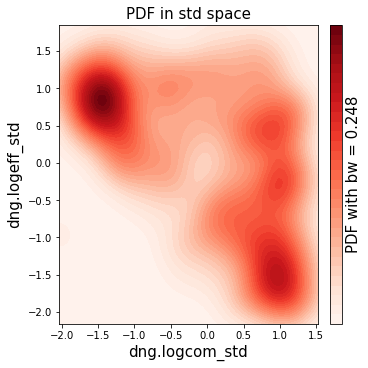

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(5,5), constrained_layout=True)

lat = 15

axs.set_title("PDF in std space", fontsize = lat)
C1 = axs.contourf(example.std_grid[0], example.std_grid[1], example.pdf_std,
                  levels=30, cmap=plt.cm.Reds)
axs.set_xlabel('dng.logcom_std', fontsize = lat)
axs.set_ylabel('dng.logeff_std', fontsize = lat)
cbar = fig.colorbar(C1, ax = axs, aspect=25, alpha=1, ticks=[], pad=-.0)

cbar.set_label(label = "PDF with bw = %.3f"%example.bw_std, fontsize=lat)

Now a comparative plot for the PDF in the real space and the standarized space:

1. At left we just evaluate the PDF from the standarized space: PDF($X^\prime$). 
2. At right, we plot the PDF obtained in the real space PDF($X$).

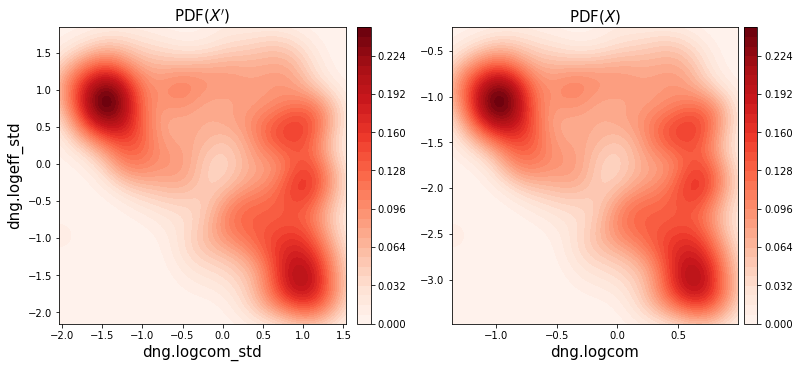

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(11,5), constrained_layout=True)

lat = 15

axs[0].set_title("PDF$(X^\prime)$", fontsize = lat)
C1 = axs[0].contourf(example.std_grid[0],  example.std_grid[1], example.pdf_std, levels=30, cmap=plt.cm.Reds)
axs[0].set_xlabel('dng.logcom_std', fontsize = lat)
axs[0].set_ylabel('dng.logeff_std', fontsize = lat)
fig.colorbar(C1, ax = axs[0], aspect=50, alpha=1,pad=-.0)

axs[1].set_title("PDF$(X)$", fontsize = lat)
C2 = axs[1].contourf(example.real_grid[0], example.real_grid[1], example.pdf_std, levels=30, cmap=plt.cm.Reds)
axs[1].set_xlabel('dng.logcom', fontsize = lat)
fig.colorbar(C2, ax = axs[1], aspect=50, alpha=1,pad=-.0)

#plt.contourf(XR, YR, PDF_p, levels=30)

# Posterior distribution and Marginalization

Let's study  the prior distribution and the respective marginalization of an interest variable. To do this, we implement the notebook `Marginal_Disrtibutions.ipynb` in which we will import our class X `optimal_pdf` and the prior information about observed systems to get the posteriors distribution of physical characteristics of  plantetary systems. Thus, we will sum over the other variables to get the marginal distribution of planetary systems. 


The notebook `3D.ipynb` is just an example of the way to get the marginal dfistributions. 